### Data preprocessing and preparation for NLP and wordcloud viz from Schindler publications
#### Make separate wordcloud for each stage in career (grad school, post doc, CDA)

In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import io

#converting pdf to text
import PyPDF2
import pdfminer
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage
laparams = pdfminer.layout.LAParams()
setattr(laparams, 'all_texts', True)

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")
#import yellowbrick as yb

pd.set_option('display.max_rows', 100000000)
pd.set_option('display.max_columns', 100000000)
pd.set_option('display.width', -1)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer 

from wordcloud import WordCloud


In [2]:
#path for papers
path = 'C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers'

#get list of directories
dir_list = os.listdir(path)
print(len(dir_list))
dir_list

3


['grad', 'postdoc', 'VA']

In [3]:
#get file paths
file_paths = []

for name in dir_list:
    print(name)
    
    new_path = path + '/' + name
    new_dir_list = os.listdir(new_path)
    print(new_path)
    print(len(new_dir_list), '\n')
    
    for file in new_dir_list:
        file_path = new_path + '/' + file
        file_paths.append(file_path)

print(len(file_paths))
file_paths[0]

grad
C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers/grad
4 

postdoc
C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers/postdoc
3 

VA
C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers/VA
4 

11


'C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers/grad/bruchas_2011.pdf'

In [4]:
def extract_text_from_pdf(pdf_path):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle, laparams=laparams)
    page_interpreter = PDFPageInterpreter(resource_manager, converter)

    with open(pdf_path, 'rb') as fh:
        for page in PDFPage.get_pages(fh, 
                                      caching=True,
                                      check_extractable=True):
            page_interpreter.process_page(page)

        text = fake_file_handle.getvalue()

    # close open handles
    converter.close()
    fake_file_handle.close()

    if text:
        return text

In [5]:
#convert each pdf to text and add to final df
papers_df = pd.DataFrame()

for file in file_paths:
    print(file)
    
    #get file into
    stage = file.split('/')[-2]
    name = file.split('/')[-1]
    
    #extract text
    text = extract_text_from_pdf(file)
    #clean up
    text = text.splitlines()
    
    #save in pandas df
    df = pd.DataFrame()
    df['name'] = [name]
    df['stage'] = [stage]
    df['text'] = [text]
    
    papers_df = pd.concat([papers_df, df], axis=0)
    
print(papers_df.shape)
papers_df = papers_df.reset_index(drop=True)

C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers/grad/bruchas_2011.pdf
C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers/grad/schindler_2010.pdf
C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers/grad/schindler_2012.pdf
C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers/grad/smith_2012.pdf
C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers/postdoc/kruse_2017.pdf
C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers/postdoc/schindler_2014.pdf
C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers/postdoc/schindler_2016.pdf
C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers/VA/hendrickson_2018.pdf
C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers/VA/logsdon_2020.pdf
C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers/VA/Schindler.2017.pdf
C:/Users/Schindler/Documents/Schindler_Lab/Papers/wordcloud_papers/VA/Schindler.2020.pdf
(11, 3)


In [6]:
#remove punctuation, lowercase words
print('removing numbers, short words, punctuation and making lowercase')
papers_df['clean_text'] = papers_df.apply(lambda row: re.sub('\W+', ' ', str(row['text'])), axis=1)
papers_df['clean_text'] = papers_df.apply(lambda row: ''.join([i for i in row['clean_text'] if not i.isdigit()]), axis=1)
papers_df['clean_text'] = papers_df.apply(lambda row: ' '.join([w for w in row['clean_text'].split() if len(w)>2]), axis=1)
papers_df['clean_text'] = papers_df['clean_text'].str.lower()

#tokenize each entry
print('tokenizing')
papers_df['clean_text'] = papers_df.apply(lambda row: word_tokenize(row['clean_text']), axis=1)

#remove stop words
print('removing stop words')
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['et', 'al', 'doi', 'figure', 'pubmed', 'mouse']
stopwords.extend(newStopWords)
papers_df['clean_text'] = [[w for w in row if w not in stopwords] for row in papers_df['clean_text']]

#lemmatize
print('lemmatizing')
lemmatizer = WordNetLemmatizer()
papers_df['clean_text'] = [[lemmatizer.lemmatize(w) for w in row] for row in papers_df['clean_text']]

# Stemming
print('stemming')
ps = PorterStemmer()
#papers_df['clean_text'] = [[ps.stem(w) for w in row] for row in papers_df['clean_text']]

removing numbers, short words, punctuation and making lowercase
tokenizing
removing stop words
lemmatizing
stemming


In [7]:
#combine all text entries grouped by stage
papers_df_groupby = papers_df.groupby(['stage'])['clean_text'].sum(axis=1).reset_index(name='clean_text_stage')

print(papers_df_groupby.shape)
papers_df_groupby

(3, 2)


,stage,clean_text_stage
0,VA,"[current, neurology, neuroscience, report, http, org, neurotrauma, sandsmark, section, editor, untangling, ptsd, tbi, challenge, strategy, clinical, care, research, rebecca, hendrickson, abigail, schindler, kathleen, pagulayan, published, online, november, government, work, copyright, protection, foreign, copyright, protection, may, apply, abstract, purpose, review, traumatic, brain, injury, tbi, post, traumatic, stress, disorder, ptsd, result, similar, injury, result, similar, symptom, problem, sleep, concentration, memory, mood, although, ptsd, persistent, sequela, due, tbi, pst, generally, viewed, pragmatically, confounded, conceptually, separable, entity, examine, emerging, evidence, emphasizing, breadth, overlap, clinical, presentation, underlying, pathophysiology, pst, ptsd, recent, finding, new, evidence, underscore, poor, specificity, symptom, etiology, emphasizes, potential, physical, brain, injury, traumatic, ...]"
1,grad,"[nih, public, access, author, manuscript, neuron, author, manuscript, available, pmc, august, published, final, edited, form, neuron, august, neuron, selective, mapk, deletion, serotonergic, neuron, produce, stress, resilience, model, depression, addiction, michael, bruchas, abigail, schindler, haripriya, shankar, daniel, messinger, mayumi, miyatake, benjamin, land, julia, lemos, catherine, hagan, john, neumaier, albert, quintana, richard, palmiter, charles, chavkin, department, pharmacology, university, washington, seattle, program, neurobiology, behavior, university, washington, seattle, department, comparative, medicine, university, washington, seattle, department, psychiatry, behavioral, neuroscience, university, washington, seattle, howard, hughes, medical, institute, department, biochemistry, university, washington, seattle, summary, maladaptive, response, stress, adversely, affect, human, behavior, yet, signaling, mechanism, underlying, stress, responsive, ...]"
2,postdoc,"[original, research, published, july, fnbeh, maladaptive, decision, making, adult, history, adolescent, alcohol, use, preclinical, model, attributable, compromised, assignment, incentive, value, stimulus, reward, learning, lauren, kruse, abigail, schindler, rapheal, williams, sophia, weber, jeremy, clark, department, psychiatry, behavioral, science, university, washington, seattle, united, state, geriatric, research, education, clinical, center, puget, sound, health, care, system, seattle, united, state, graduate, program, neuroscience, university, washington, seattle, united, state, according, recent, report, alcohol, remains, number, one, substance, used, abused, adolescent, despite, public, health, effort, curb, use, adolescence, critical, period, biological, maturation, brain, development, particularly, mesocorticolimbic, dopamine, system, undergoes, substantial, remodeling, circuit, implicated, complex, decision, making, incentive, ...]"


VA


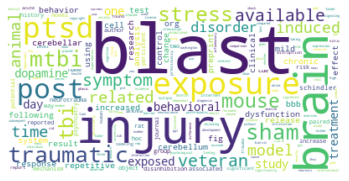

grad


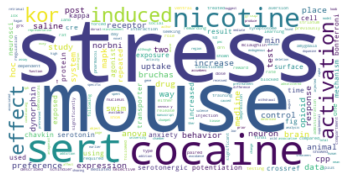

postdoc


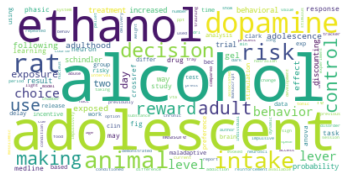

In [22]:
#build a word cloud for each stage
for index, row in papers_df_groupby.iterrows():
    
    print(row['stage'])
    
    text = str(row['clean_text_stage'])

    wordcloud = WordCloud(collocations=False, background_color="white").generate(text.replace("'",''))

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(str(row['stage'] + '_wordcloud.png'))
    plt.show()